<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/code/D2l_10_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

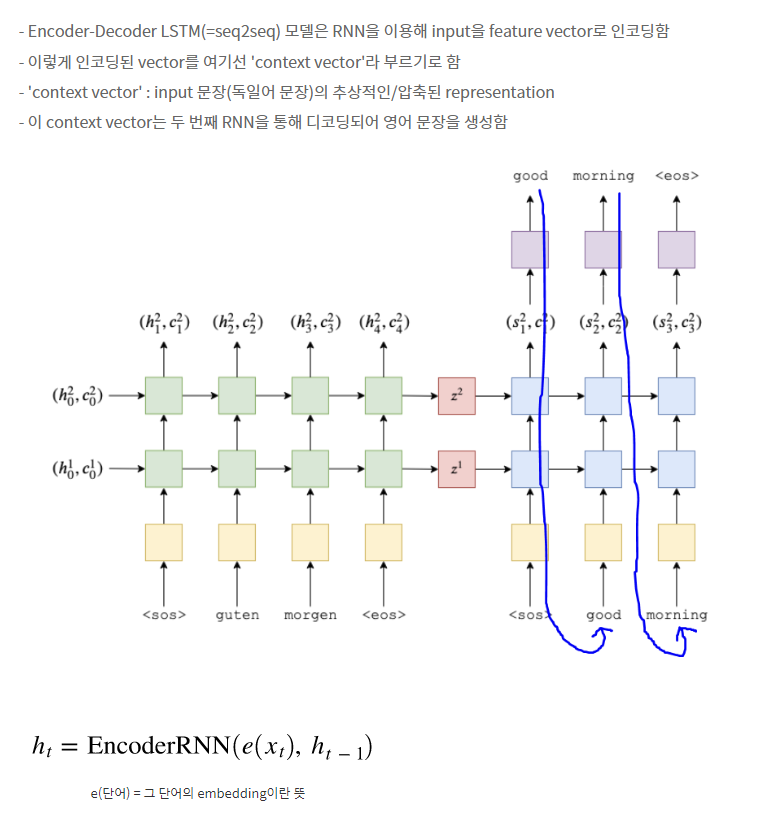

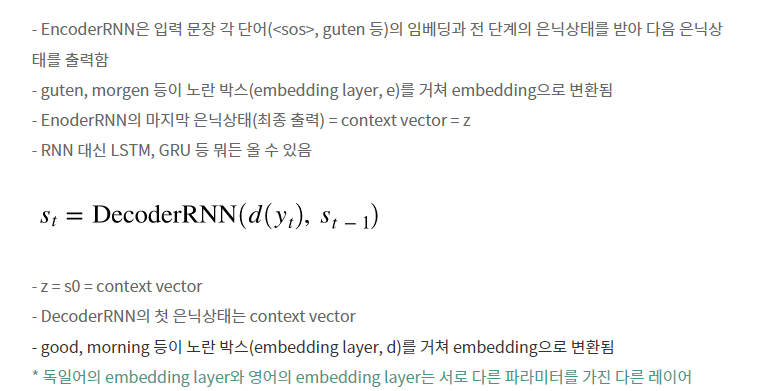

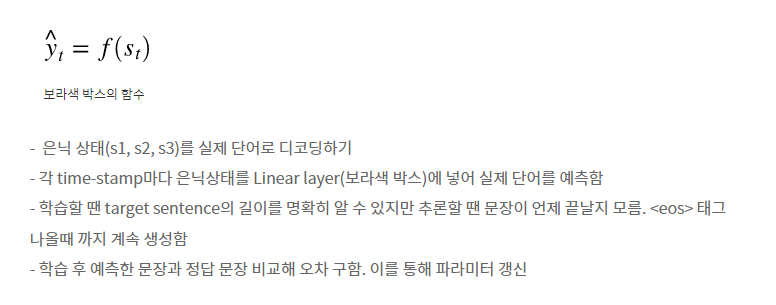

### Load Dataset

In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil

import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

1. 사용할 샘플 크기 지정

In [2]:
num_samples = 33000

In [6]:
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

--2024-02-21 04:12:17--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  37.0MB/s    in 0.2s    

2024-02-21 04:12:17 (37.0 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


2. 전처리 - 악센트 삭제 및 \<eos> \<sos> 삽입

In [3]:
# 전처리 함수
def unicode_to_ascii(sentence):
    # 프랑스어 악센트 삭제
    return ''.join(c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    # 악센트 삭제 함수 호출
    sentence = unicode_to_ascii(sentence.lower())

    # 단어와 구두점 사이 공백 만듦 , he is a boy. => he is a boy .
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고 전부 공백 변환
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)

    # 다수 개의 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence

def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            # src와 trg 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')
            print("src_line: ", src_line)
            print("tar_line: ", tar_line)

            # src 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]
            print("src 전처리됨: ", src_line)

            # trg 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]
            print("tar 전처리됨: ", tar_line_out)

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break
    return encoder_input, decoder_input, decoder_target

In [4]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [7]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tar 전처리됨:  ['la', 'mouche', 'est', 'un', 'insecte', '.', '<eos>']
src_line:  A guard is outside.
tar_line:  Un garde se trouve à l'extérieur.
src 전처리됨:  ['a', 'guard', 'is', 'outside', '.']
tar 전처리됨:  ['un', 'garde', 'se', 'trouve', 'a', 'l', 'exterieur', '.', '<eos>']
src_line:  A lot has happened.
tar_line:  Il s'est passé beaucoup de choses.
src 전처리됨:  ['a', 'lot', 'has', 'happened', '.']
tar 전처리됨:  ['il', 's', 'est', 'passe', 'beaucoup', 'de', 'choses', '.', '<eos>']
src_line:  A lot of fish died.
tar_line:  Beaucoup de poissons ont péri.
src 전처리됨:  ['a', 'lot', 'of', 'fish', 'died', '.']
tar 전처리됨:  ['beaucoup', 'de', 'poissons', 'ont', 'peri', '.', '<eos>']
src_line:  A revolt broke out.
tar_line:  Une révolte éclata.
src 전처리됨:  ['a', 'revolt', 'broke', 'out', '.']
tar 전처리됨:  ['une', 'revolte', 'eclata', '.', '<eos>']
src_line:  A storm is brewing.
tar_line:  Une tempête se prépare.
src 전처리됨:  ['a', 'storm', 'is', 'brewing', '.']
tar 전처리됨:  ['un

3. 전처리 - 단어 집합 생성

In [8]:
# 단어 집합 생성
def build_vocab(sentences):
    word_list = []

    for sentence in sentences:
        for word in sentence:
            word_list.append(word)

    # 각 단어별로 등장 빈도 계산해 빈도 높은 순으로 정렬
    word_counts = Counter(word_list)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)

    word_to_index = {}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK'] = 1

    # 빈도 높은 단어일수록 낮은 정수 부여
    for index, word in enumerate(vocab):
        word_to_index[word] = index + 2

    return word_to_index

In [9]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("영어 단어 집합 크기: {:d}, 프랑스어 단어 집합 크기: {:d}".
      format(src_vocab_size, tar_vocab_size))

영어 단어 집합 크기: 4488, 프랑스어 단어 집합 크기: 7884


4. 전처리 - 단어 정수 인코딩

In [10]:
# 정수로부터 단어 얻는 딕셔너리
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

def texts_to_sequences(sentences, word_to_index):
    encoded_X_data = []
    for sentence in tqdm(sentences):
        index_sequences = []
        for word in sentence:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)
    return encoded_X_data

In [11]:
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)

100%|██████████| 33000/33000 [00:00<00:00, 94661.29it/s] 


In [12]:
# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
    print(f"Index: {i}, 정수 인코딩 전: {item1}, 정수 인코딩 후: {item2}")

Index: 0, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 1, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 2, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 3, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 4, 정수 인코딩 전: ['hi', '.'], 정수 인코딩 후: [742, 2]


5. 전처리 - 패딩

In [13]:
def pad_sequences(sentences, max_len=None):
    # 최대 길이 주어지지 않은 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [14]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

데이터 크기 확인

In [15]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


데이터 섞기

In [16]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [10625 19300 26139 ... 28936 17476 13730]


In [17]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [18]:
print([index_to_src[word] for word in encoder_input[30996]])
print([index_to_tar[word] for word in decoder_input[30996]])
print([index_to_tar[word] for word in decoder_target[30996]])

['i', 'was', 'not', 'pleased', '.', '<PAD>', '<PAD>']
['<sos>', 'je', 'ne', 'fus', 'pas', 'content', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['je', 'ne', 'fus', 'pas', 'content', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용

In [19]:
n_of_val = int(33000*0.1)
print('number of test dataset: ', n_of_val)

number of test dataset:  3300


In [20]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [21]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


### 번역 모델 구현
* 인코더-디코더
* Seq2Seq

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256

In [23]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, cell) = self.lstm(x)

        return hidden, cell

In [24]:
class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size)

    def forward(self, x, hidden, cell):
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        output = self.fc(output)

        return output, hidden, cell

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tar):
        hidden, cell = self.encoder(src)
        output, _, _ = self.decoder(tar, hidden, cell)
        return output

In [26]:
encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [27]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4488, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7884, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7884, bias=True)
  )
)


### Train & Evaluation

In [28]:
def evaluation(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순방향 전파
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산(패딩 토큰 제외)
            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()
    return total_loss / len(dataloader), total_correct/total_count

In [29]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

In [30]:
# 데이터셋 및 데이터로더 생성
batch_size = 128
train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 학습 설정
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4488, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7884, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7884, bias=True)
  )
)

In [31]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, criterion, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, criterion, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}| Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. Saving checkpoint...')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch: 1/5 | Train Loss: 2.8943 | Train Acc: 0.5323| Valid Loss: 3.0143 | Valid Acc: 0.5250
Validation loss improved from inf to 3.0143. Saving checkpoint...
Epoch: 2/5 | Train Loss: 2.2534 | Train Acc: 0.6076| Valid Loss: 2.4847 | Valid Acc: 0.5910
Validation loss improved from 3.0143 to 2.4847. Saving checkpoint...
Epoch: 3/5 | Train Loss: 1.8539 | Train Acc: 0.6466| Valid Loss: 2.2008 | Valid Acc: 0.6194
Validation loss improved from 2.4847 to 2.2008. Saving checkpoint...
Epoch: 4/5 | Train Loss: 1.5581 | Train Acc: 0.6864| Valid Loss: 2.0131 | Valid Acc: 0.6424
Validation loss improved from 2.2008 to 2.0131. Saving checkpoint...
Epoch: 5/5 | Train Loss: 1.3006 | Train Acc: 0.7216| Valid Loss: 1.8658 | Valid Acc: 0.6597
Validation loss improved from 2.0131 to 1.8658. Saving checkpoint...


In [32]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 1.8658
Best model validation accuracy: 0.6597


In [33]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])

3
4


### 번역

전체적인 번역 단계

    1) 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2) 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3) 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [34]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence

In [35]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

[   3   52 1562    2    0    0    0]
[   3   13   89   34 3706    2    0    0    0    0    0    0    0    0
    0    0]
[  13   89   34 3706    2    4    0    0    0    0    0    0    0    0
    0    0]


In [36]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>를 디코더의 첫 입력으로 설정
    # unsqueeze(0)은 배치 차원을 추가하기 위함
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)
    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트 맥스 회귀를 수행, 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 4:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적되었다 최종 번역 시퀀스로 리턴함!
        decoded_tokens.append(output_token)

        # 현재 시점의 예측, 다음 시점의 입력으로 사용됨
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [38]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=5ecf8c3dd38289cb557d8dbce733f6001731a2d50daeed3bee25b3d32eb15c29
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [39]:
from googletrans import Translator
translator = Translator()

for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("(한국어) :", translator.translate(seq_to_src(encoder_input_test[seq_index]), src='en', dest='ko').text)
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("(한국어) :", translator.translate(seq_to_tar(decoder_input_test[seq_index]), src='fr', dest='ko').text)
  print("번역문장 :",translated_text)
  print("(한국어) :", translator.translate(translated_text, src='fr', dest='ko').text)
  print("-"*50)

입력문장 : tom will obey you . 
(한국어) : 톰은 당신에게 순종 할 것입니다.
정답문장 : tom vous obeira . 
(한국어) : 톰은 당신에게 순종 할 것입니다.
번역문장 : tom vous reposer .
(한국어) : 톰 휴식.
--------------------------------------------------
입력문장 : only tom stayed . 
(한국어) : 톰 만 머물렀다.
정답문장 : seul tom est reste . 
(한국어) : 톰만이 머무는 것입니다.
번역문장 : tom s est assis en colere .
(한국어) : Tom S는 분노에 앉아 있습니다.
--------------------------------------------------
입력문장 : let me sleep . 
(한국어) : 날 자게 내버려둬 .
정답문장 : laissez moi dormir . 
(한국어) : 날 자게 내버려둬 .
번역문장 : laisse moi tranquille .
(한국어) : 날 내버려 두십시오.
--------------------------------------------------
입력문장 : answer my question . 
(한국어) : 내 질문에 대답 .
정답문장 : repondez a ma question ! 
(한국어) : 내 질문에 대답 !
번역문장 : appelle mon bras .
(한국어) : 내 팔에 전화하십시오.
--------------------------------------------------
입력문장 : ask anybody . 
(한국어) : 누구든지 물어보세요.
정답문장 : demandez a n importe qui ! 
(한국어) : 누구든지 물어봐!
번역문장 : demande a personne !
(한국어) : 누구든지 물어봐!
--------------------------------------------------
